In [135]:
import bs4
import pandas as pd
import numpy as np
import tqdm

In [2]:
with open('test.html') as file:
    content = file.read()

In [3]:
tree = bs4.BeautifulSoup(content)

In [46]:
import xml.etree.ElementTree as et


def html2list(table):
    if isinstance(table, str):
        table = et.fromstring(table)

    # parse caption
    caption = table.find("caption")
    caption = caption.text if caption is not None else ''

    # parse table
    content = []
    rowspans = {}
    contents = {}

    for elem in table.iter(tag="tr"):
        row = []
        cell_index = 0

        for cell in list(elem):
            cell_text = ''.join(cell.itertext()).strip()

            rowspan = cell.get("rowspan")
            rowspans[cell_index] = int(rowspan) if rowspan else (rowspans.get(cell_index, 0))
            if rowspan is not None:
                contents[cell_index] = cell_text

            if rowspan is None and rowspans[cell_index] > 0:
                row.append(contents[cell_index])
                rowspans[cell_index] -= 1

            colspan = cell.get("colspan")
            colspan = int(colspan) if colspan else 1
            row.extend([''.join(cell_text)] * colspan)

            cell_index += colspan
        content.append(row)

    return caption, content

In [55]:
def get_dataframe_from_html_table(html_table):
    caption, table = html2list(str(html_table))
    return caption, pd.DataFrame(table)

tables = []
for table in tree.find_all('table'):
    caption, df = get_dataframe_from_html_table(table)
    tables.append({'data': df, 'meta': caption})
tables[0]['data'].head(50).tail(10) # 40:50

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
40,458,,,49 396,,,,,,,,,65 849,None,None,None
41,459,,,12 047,,,,,,,,,13 822,None,None,None
42,474,,,854 066,,,,,,,,,2 081 019,None,None,None
43,496,,,500 000,,,,,,,,,500 000,None,None,None
44,501,,,0,,,,,,,,,0,None,None,None
45,60.0,,,123 963,,,,,,,,,281 347,None,None,None
46,604,,,18 240,,,,,,,,,19 049,None,None,None
47,608,,,101 726,,,,,,,,,101 867,None,None,None
48,609,,,495 884,,,,,,,,,535 361,None,None,None
49,706,,,3 642 159,,,,,,,,,4 472 496,None,None,None


# pip install pypdf
# pip install "camelot-py[base]"
# conda install -c conda-forge camelot-py

In [41]:
from typing import List


def remove_hyphens(text: str) -> str:
    """

    This fails for:
    * Natural dashes: well-known, self-replication, use-cases, non-semantic,
                      Post-processing, Window-wise, viewpoint-dependent
    * Trailing math operands: 2 - 4
    * Names: Lopez-Ferreras, VGG-19, CIFAR-100
    """
    lines = [line.rstrip() for line in text.split("\n")]

    # Find dashes
    line_numbers = []
    for line_no, line in enumerate(lines[:-1]):
        if line.endswith("-"):
            line_numbers.append(line_no)

    # Replace
    for line_no in line_numbers:
        lines = dehyphenate(lines, line_no)

    return "\n".join(lines)


def dehyphenate(lines: List[str], line_no: int) -> List[str]:
    next_line = lines[line_no + 1]
    word_suffix = next_line.split(" ")[0]

    lines[line_no] = lines[line_no][:-1] + word_suffix
    lines[line_no + 1] = lines[line_no + 1][len(word_suffix) :]
    return lines


def remove_footer(extracted_texts: list[str], page_labels: list[str]):
    def remove_page_labels(extracted_texts, page_labels):
        processed = []
        for text, label in zip(extracted_texts, page_labels):
            text_left = text.lstrip()
            if text_left.startswith(label):
                text = text_left[len(label) :]

            text_right = text.rstrip()
            if text_right.endswith(label):
                text = text_right[: -len(label)]

            processed.append(text)
        return processed

    extracted_texts = remove_page_labels(extracted_texts, page_labels)
    return extracted_texts

In [22]:
def parse_pdf_with_camelot(path):
    tables = camelot.read_pdf('camelot_example.pdf')
    dfs = []
    for table in tables:
        dfs.append(table.df)
    return dfs

def parse_tables_from_pdf(path):
    camelot_tables = parse_pdf_with_camelot(path)
    if camelot_tables:
        return camelot_tables


In [19]:
import camelot
tables = camelot.read_pdf('camelot_example.pdf')
tables

<TableList n=1>

In [21]:
tables[0].df

,0,1,2,3,4,5,6
0,Cycle \nName,KI \n(1/km),Distance \n(mi),Percent Fuel Savings,,,
1,,,,Improved \nSpeed,Decreased \nAccel,Eliminate \nStops,Decreased \nIdle
2,2012_2,3.30,1.3,5.9%,9.5%,29.2%,17.4%
3,2145_1,0.68,11.2,2.4%,0.1%,9.5%,2.7%
4,4234_1,0.59,58.7,8.5%,1.3%,8.5%,3.3%
5,2032_2,0.17,57.8,21.7%,0.3%,2.7%,1.2%
6,4171_1,0.07,173.9,58.1%,1.6%,2.1%,0.5%


In [42]:
def preprocess_pdf_text(text):
    text = remove_hyphens(text)

In [ ]:
def preprocess_page(texts):
    remove_footer(

In [45]:
from pypdf import PdfReader

reader = PdfReader("vtb_example.pdf")
texts = []
for i, page in enumerate(reader.pages):
    texts.append({'text': page.extract_text(), 'page_num': i, 'images': page.images})
len(texts)

117

In [46]:
! pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.2 MB/s eta 0:00:00a 0:00:01


In [48]:
import pdfplumber

In [114]:
def get_settings_variants():
    variants = []
    for vertical in ['text', 'lines']:
        for horizontal in ['text', 'lines']:
            for snap_y_tolerange in [3]:
                for intersection_x_tolerance in [10]:
                    variants.append({
                        "vertical_strategy": vertical,
                        "horizontal_strategy": horizontal,
                        "snap_y_tolerance": snap_y_tolerange,
                        "intersection_x_tolerance": intersection_x_tolerance,
                    })
    return variants

In [145]:
def get_df_from_page(page, settings):
    table = page.extract_table(settings)
    if table:
        return pd.DataFrame(table)

def search_best_table(page):
    dfs = []
    for variant in get_settings_variants():
        df = get_df_from_page(page, variant)
        if df is not None:
            # проверяем, стал ли отличаться датафрейм от предыдущего
            if len(dfs) == 0 or not df.equals(dfs[-1]):
                dfs.append(df)
                
    # определяем, что лучший датафрейм - тот, где больше всего не-null значений
    # (наивная эвристика)
    best_df_idx = np.argmax(map(lambda x: x.shape[0] * x.shape[1], dfs))
    best_df = dfs[best_df_idx]
    if get_float_values_ratio(best_df) > 0.1:
        return best_df
    return None

In [146]:
df = search_best_table(pdf.pages[98])

In [185]:
def get_float_values_ratio(df):
    if df is None:
        return
    float_val_count = 0
    total_count = 0
    for val in df.values.flatten().tolist():
        try:
            float(val)
            float_val_count += 1
        except ValueError:
            pass
        except TypeError:
            pass
        total_count += 1
    float_ratio = float_val_count / total_count
    return float_ratio

In [167]:
parsed_dfs = []
for i, page in enumerate(tqdm.tqdm(pdf.pages)):
    df = search_best_table(page)
    if df is not None:
        parsed_dfs.append({'page': i, 'df': df})
# ratio_df = pd.DataFrame(ratio_df)

100%|█████████████████████████████████████████| 117/117 [00:19<00:00,  6.12it/s]


In [191]:
def preprocess_df(df):
    to_replace = ['X', 'Х', '']
    df = df.replace(to_replace, None).dropna(axis=0, how='all').dropna(axis=1, how='all')
    df['_row_float_ratio'] = df.apply(get_float_values_ratio, axis=1)
    df = df[df['_row_float_ratio'] > 0.2]
    df = df.drop('_row_float_ratio', axis=1)
    return df

In [193]:
df = parsed_dfs[0]['df']
preprocess_df(df)

,0,1,2,3,4
18,ВИДЫ РЕСУРСОВ,None,2022,2021,2020
20,Тепловая энергия (Гкал),144,942 1,72 663 133,620
22,Электроэнергия (тыс. кВт • ч),212,871 2,29 614 237,553
24,Газ (тыс. м3),2,836,1 860,2 618
26,Бумага (т),1,522,2 066 2,455
28,Питьевая вода (тыс. л),3,850,3 592 2,958


In [153]:
df

In [141]:
search_best_table(pdf.pages[90])

,0,1,2,3,4
0,пе,"реработку, в том числе 418,9 т бумаги.",Сотрудники все,активнее участвуют,
1,в р,азличных инициативах по раздельно,му сбору отходов,:,
2,,,,,
3,•,более 174 кг батареек собрано с 2021,года в наиболее,крупных офисных,
4,,зданиях Банка в Москве (башни «Фед,"ерация Запад», «",Евразия» в комплек,се
5,,«Москва-Сити» и ДО «Воронцовский»,) и передано Фед,еральному,
6,,экологическому оператору для утили,зации;,,
7,,,,,
8,•,в мае 2022 года ВТБ присоединился к,российскому эк,олого-,
9,,благотворительному волонтерскому,проекту «Добрые,крышечки» (г. Моск,ва)


In [99]:
dfs[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,НОМЕР,НАИМЕНОВАНИЕ СТАТЬИ,,УСТАВНОЙ,СОБСТВЕН-,ЭМИССИОН-,ПЕРЕОЦЕНКА,ПЕРЕОЦЕНКА,УВЕЛИЧЕНИЕ,ПЕРЕОЦЕНКА,РЕЗЕРВНЫЙ,ДЕНЕЖНЫЕ,ИЗМЕНЕНИЕ,ОЦЕНОЧНЫЕ,НЕРАСПРЕ-,,ИТОГО
1,СТРОКИ,,,КАПИТАЛ,НЫЕ АКЦИИ,НЫЙ ДОХОД,ПО СПРАВЕД-,ОСНОВНЫХ,(УМЕНЬШЕНИЕ),ИНСТРУМЕНТОВ,ФОНД,СРЕДСТВА,СПРАВЕДЛИВОЙ,РЕЗЕРВЫ ПОД,ДЕЛЕННАЯ,,ИСТОЧНИКИ
2,,,,,"(ДОЛИ), ВЫ-",,ЛИВОЙ СТОИ-,СРЕДСТВ И,ОБЯЗАТЕЛЬСТВ,ХЕДЖИРО-,,БЕЗВОЗМЕЗД-,СТОИМОСТИ,ОЖИДАЕМЫЕ,ПРИБЫЛЬ,,КАПИТАЛА
3,,,,,КУПЛЕННЫЕ У,,МОСТИ ЦЕН-,НЕМАТЕРИАЛЬ-,(ТРЕБОВАНИЙ),ВАНИЯ,,НОГО ФИНАН-,ФИНАНСОВОГО,КРЕДИТНЫЕ,(УБЫТОК),,
4,,,,,АКЦИОНЕРОВ,,"НЫХ БУМАГ,","НЫХ АКТИВОВ,",ПО ВЫПЛАТЕ,,,СИРОВАНИЯ,ОБЯЗАТЕЛЬ-,УБЫТКИ,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,,(участников),,,,,,,,,,,,,,,
64,,,,,,,,,,,,,,,,,
65,23,Прочие движения,,0,X,0,0,0,0,X,0,0,0,0,4 271 670,,4 271 670
66,,,,,,,,,,,,,,,,,


In [63]:
table_settings = {
    "vertical_strategy": "text",
    "horizontal_strategy": "lines",
    "snap_y_tolerance": 5,
    "intersection_x_tolerance": 15,
}

      0                                                  1   \
0     12      Данные за соответствующ\nпериод прошлого года   
1     13                            Данные на начало отчетн   
2     14            Влияние изменений пол\nучетной политики   
3     15                              Влияние исправления о   
4     16                            Данные на начало отчетн   
5     17                            Совокупный доход за отч   
6   17.1                                   прибыль (убыток)   
7   17.2                             прочий совокупный дохо   
8     18                                     Эмиссия акций:   
9   18.1                              номинальная стоимость   
10  18.2                                  эмиссионный доход   
11    19  Собственные акции\n(доли), выкупленные у\nакци...   
12  19.1                                       приобретения   
13  19.2                                            выбытия   
14    20     Изменение стоимости ос\nсредств и нематери

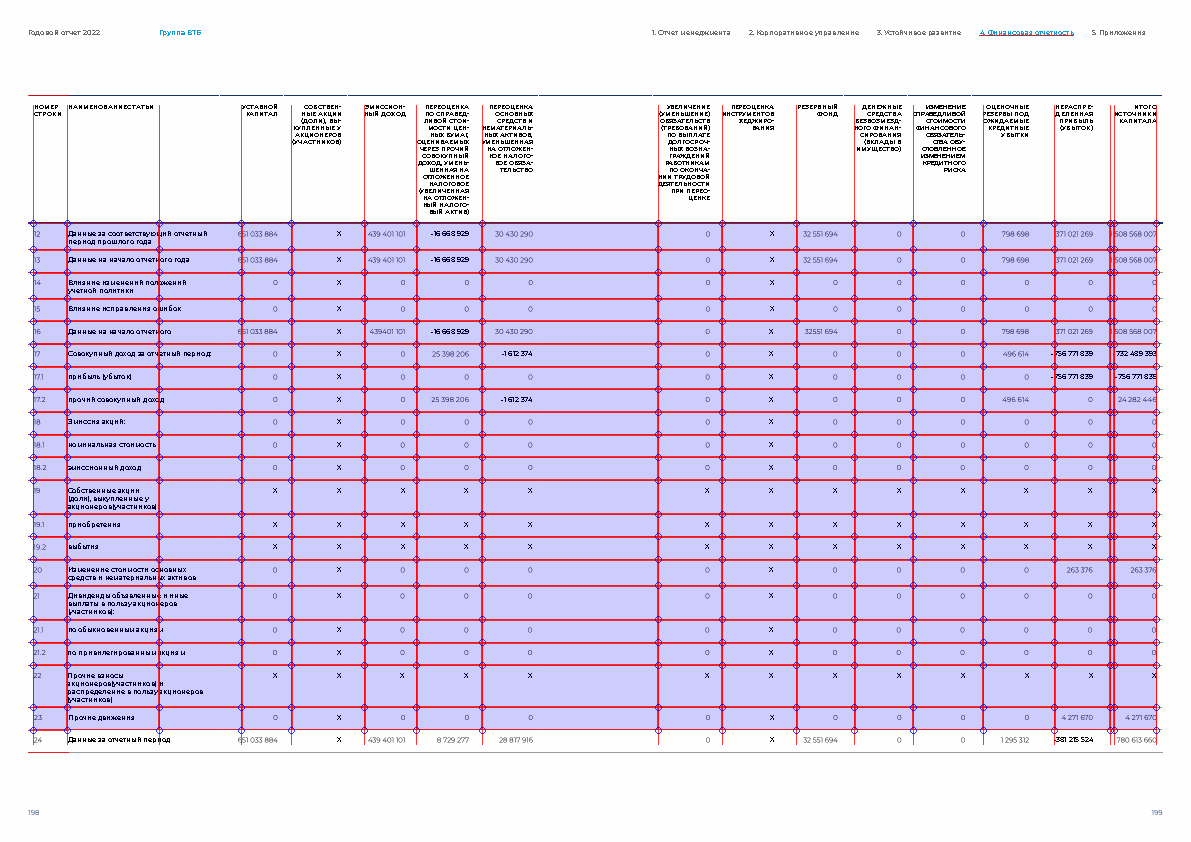

In [66]:
pdf = pdfplumber.open("vtb_example.pdf")
page = pdf.pages[99]
table = page.extract_table(table_settings)
print(pd.DataFrame(table))
im = page.to_image()
im.reset().debug_tablefinder(table_settings)
# im.clear()debug_tablefinder()

In [18]:
count = 0
for page in reader.pages:
    for image in page.images:
        with open('images/' + str(count) + image.name, "wb") as fp:
            fp.write(image.data)
            count += 1

In [34]:
one_page_table = reader.pages[97].extract_text()

values = []
for row in one_page_table.split('\n'):
    values_row = []
    for cell in row.split('\t'):
        values_row.append(cell)
    values.append(values_row)
pd.DataFrame(values)

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,194 195Г одовой отчет 2022 Группа ВТБ 1.,Отчет,менеджмента,,,,,,,,...,,,,,,5.,Приложения,,,
1,НОМЕР,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,СТРОКИ НАИМЕНОВАНИЕ ИНСТРУМЕНТА (ПОКАЗАТЕЛЯ) С...,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,И Н С Т Р У М Е Н Т А,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,(ВЕЛИЧИНА,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,84Текущее,ограничение,на,включение,в,состав,источников,дополнительного,,None,...,None,None,None,None,None,None,None,None,None,None
113,капитала,"инструментов,",подлежащих,поэтапному,исключению,из,расчета,,None,None,...,None,None,None,None,None,None,None,None,None,None
114,собственных,средств,(капитала)0 27 810 823,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
115,85Часть,"инструментов,",не,включенная,в,состав,источников,дополнительного,,None,...,None,None,None,None,None,None,None,None,None,None
